# PatientFi Interview

Checklist:
- <input type="checkbox" > Imports
- <input type="checkbox" > Data basic analytics
- <input type="checkbox" > Preparations
- <input type="checkbox" > Correlations breakdown
- <input type="checkbox" > Finalize train set datasets
- <input type="checkbox" > Determine feature importance (multiple models)
- <input type="checkbox" > model comparuson
- <input type="checkbox" > Try neural networks
- <input type="checkbox" > Pipelining and Stacking of models
- <input type="checkbox" > Report in LaTex


## Notes

- DS Shape: 148 Features, 199999 Records

## Null Analysis

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
# ----------------------------------------


## Data Reformatting
Since we're going to use KNN to impute, let's go ahead and prepare the other colmuns before imputing.
- Create Dummy Variables:
'term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag'

- To be reformatted:
'issue_d' , 'zip_code' , 'sub_grade' , 'earliest_cr_line' 

- To be numerically categorated: 
'loan_status'

['Charged Off', 'Current', 'Late (31-120 days)', 'In Grace Period', 'Default', 'Fully Paid', 'Late (16-30 days)'] 


<ipython-input-31-6bb861d7f4d9>:16: DtypeWarning: Columns (18,56) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = pd.read_csv('data.csv')


                              feature  nan_percent
0                                  id          0.0
1                           tax_liens          0.0
2                     tot_hi_cred_lim          0.0
3                   total_bal_ex_mort          0.0
4                         tot_cur_bal          0.0
..                                ...          ...
143                sec_app_revol_util        100.0
144                  sec_app_open_acc        100.0
145                  sec_app_mort_acc        100.0
146          sec_app_earliest_cr_line        100.0
147  sec_app_chargeoff_within_12_mths        100.0

[148 rows x 2 columns]


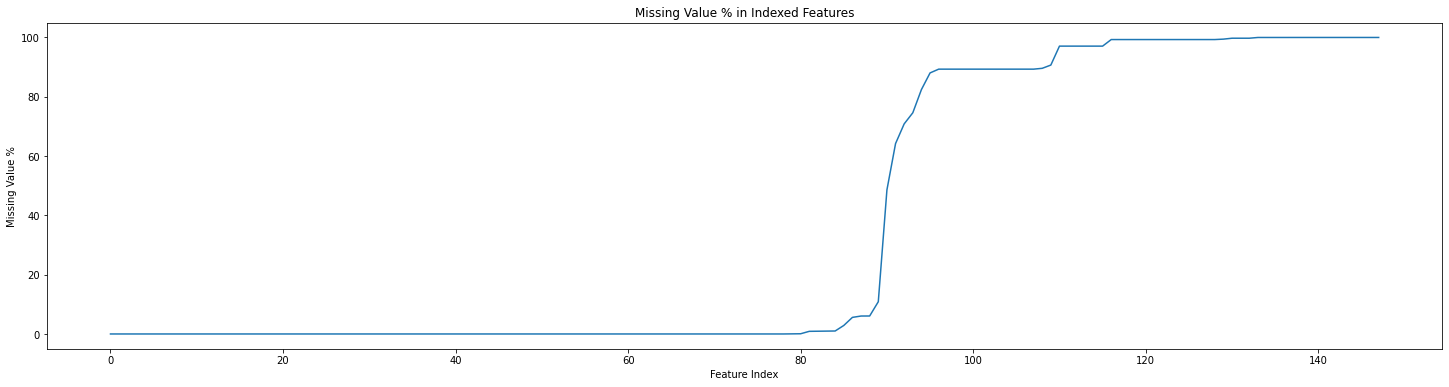

                  feature  nan_percent
0               loan_amnt     0.000000
1                mort_acc     0.000000
2          mo_sin_rcnt_tl     0.000000
3   mo_sin_rcnt_rev_tl_op     0.000000
4    mo_sin_old_rev_tl_op     0.000000
..                    ...          ...
82       percent_bc_gt_75     1.003505
83     mo_sin_old_il_acct     2.870514
84       num_tl_120dpd_2m     5.596528
85             emp_length     6.051530
86  mths_since_recent_inq    10.875054

[87 rows x 2 columns]


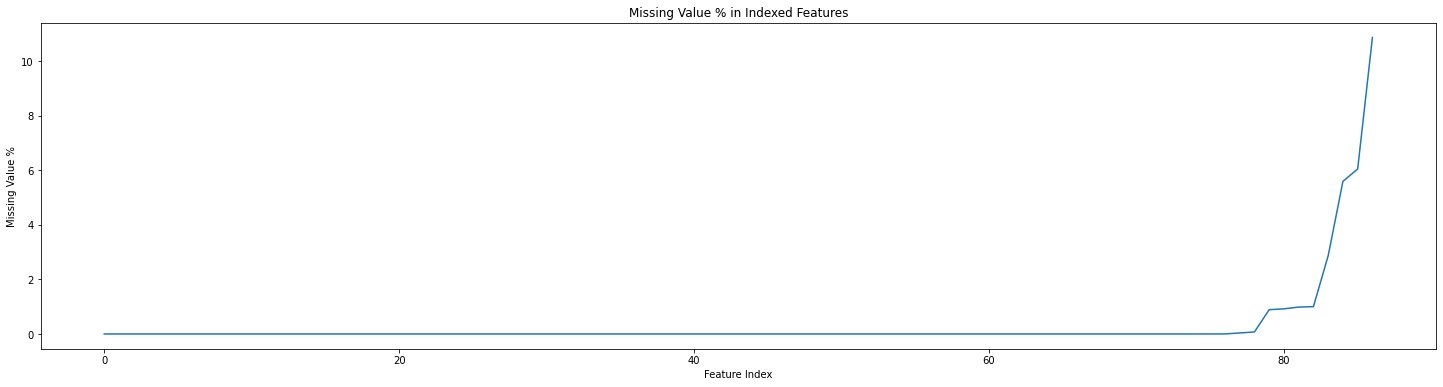

                  feature  nan_percent
0               loan_amnt          0.0
1   num_accts_ever_120_pd          0.0
2   mths_since_recent_inq          0.0
3    mths_since_recent_bc          0.0
4                mort_acc          0.0
..                    ...          ...
82             revol_util          0.0
83              revol_bal          0.0
84                pub_rec          0.0
85        total_pymnt_inv          0.0
86   debt_settlement_flag          0.0

[87 rows x 2 columns]


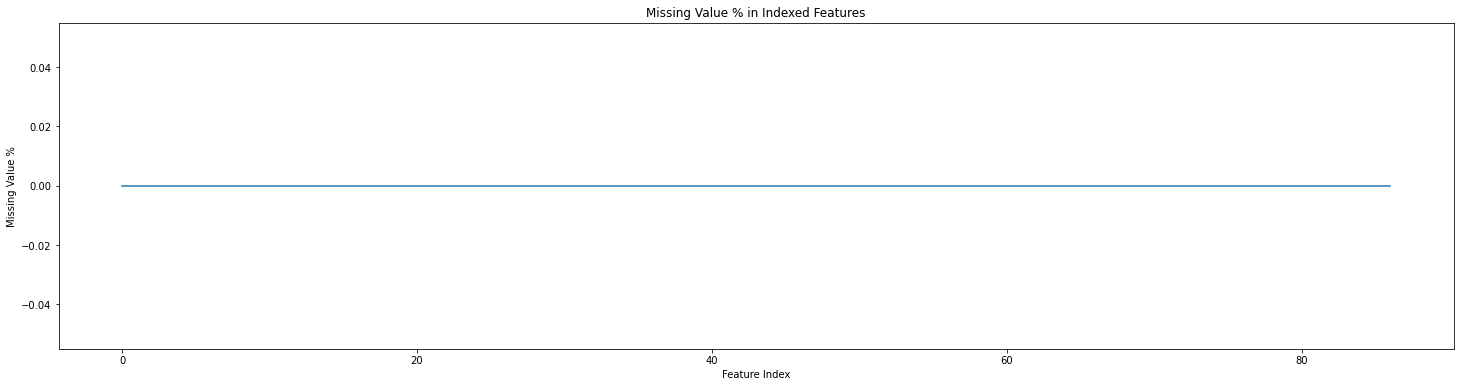

[]


In [31]:
# ----- TOKERNIZER ----------
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import RegexpTokenizer
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# best_tokenizer = RegexpTokenizer(r'\w+')

# ds['emp_title'] = [best_tokenizer.tokenize(str(x).lower()) for x in ds['emp_title']]
# ds['emp_title'] = ds['emp_title'].apply(lambda x: [w for w in x if not w in stop_words])
# ds['emp_title'] = [' '.join(x) for x in ds['emp_title']]

# print('UNIQUE emp_title INSTANCES:   ' + str(len(list(set(ds['emp_title'])))))

ds = pd.read_csv('data.csv')
def check_nulls(ds):
    percent_missing = ds.isnull().sum() * 100 / len(ds)
    ds_null = pd.DataFrame({'feature': ds.columns, 'nan_percent': percent_missing})
    ds_null.sort_values('nan_percent', inplace = True)
    ds_null.index = range(len(ds_null))
    print(ds_null)
    plt.figure(figsize = (25, 6))
    plt.plot(ds_null.index, ds_null['nan_percent'])
    plt.xlabel('Feature Index')
    plt.ylabel('Missing Value %')
    plt.title('Missing Value % in Indexed Features')
    plt.show()
    return list(ds_null[ds_null['nan_percent'] > 0.0]['feature'])

columns_missing_values = check_nulls(ds)
ds.drop(['addr_state', 'emp_title', 'id'], axis = 1, inplace = True)
ds = ds.dropna(thresh=(len(ds) * .75), axis=1) # DROP ALL COLUMNS WITH 75% or more missing values
columns_missing_values = check_nulls(ds)


# ---------------- LABELING & DUMMY DATA ----------------------
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# ds['loan_status'] = label_encoder.fit_transform(ds['loan_status'])
cols_tobreak = ['term', 'grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
# ds = pd.get_dummies(ds, columns = cols_tobreak)
for c in cols_tobreak:
    ds[c] = label_encoder.fit_transform(ds[c])


# ----- CONVERTING NON NUMERIC COLUMNS WITH MISSING VALUES TO NUMERIC FOR IMPUTATION ---------------
def calculate_daydiff(dt):
    if dt == None or not isinstance(dt, str) : return None
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # print('m: ' + str(dt[0:3] + ' , d: ' + str(dt[4:])))
    m, d = dt[0:3], dt[4:]
    return sum(days[0:months.index(m)]) + int(d)

def convert_yearsnum(s):
    if s == None or not isinstance(s, str) : return None
    elif s == '< 1 year': return 0
    elif s == '10+ years': return 10
    else:
        return int(s[0:1])

def calculate_monthdiff(d):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    m, y = d[0:3], int(d[4:])
    if(y < 0): return ((100 - y) + 22) * 12 + len(months) - months.index(m) # 22 bc current year
    else: return (22 - y) * 12 + len(months) - months.index(m)

def loan_status_labeler(x):
    if x == 'Charged Off': return 1
    else: return 0


ds['last_credit_pull_d'] = ds['last_credit_pull_d'].apply(lambda x: calculate_daydiff(x))
ds['last_pymnt_d'] = ds['last_pymnt_d'].apply(lambda x: calculate_daydiff(x))
ds['issue_d'] = ds['issue_d'].apply(lambda x: calculate_daydiff(x))
ds['emp_length'] = ds['emp_length'].apply(lambda x: convert_yearsnum(x))
ds['zip_code'] = ds['zip_code'].apply(lambda x: x[0:3])
ds['sub_grade'] = ds['sub_grade'].apply(lambda x: x[1:])
ds['earliest_cr_line'] = ds['earliest_cr_line'].apply(lambda x: calculate_monthdiff(x))
ds['loan_status'] = ds['loan_status'].apply(lambda x: loan_status_labeler(x))


# -------------------- IMPUTING (median) -----------------------
from sklearn.impute import SimpleImputer
imp_median = SimpleImputer(strategy = 'median') #for median imputation replace 'mean' with 'median'
cols_to_impute = list(ds[columns_missing_values].describe().columns)
imputed = imp_median.fit_transform(ds[cols_to_impute])
imputed = imputed.T
i = 0
for c in cols_to_impute:
    ds[c] = imputed[i]
    i += 1

print(check_nulls(ds))


# NOTE:
we notice a lot of the columns with NaN values are fully null (every record) for the sake of model effectiveness, let's drop them from the effective dataset

- ds = original dataset
- ds_null the dataset of all columns with null values (for the sake of dropping)

We see that once we got rid of the columns with 75% of missing values or more, most columns have at most 10.87 % NaN value, which can imputed

## Imputing

before we impute, we notice from ds.describe() that some of the values we wish to impute are not numerical but can be converted to numeric ('Mar-18' == 177, '10+years' = 10)
Let's do that first and then impute then too.

'last_credit_pull_d', 'last_pymnt_d', 'emp_length', 'emp_title'

Then we are left wuth only one colummn that is not numerical with missing values ('emp_title') we'll apply a tokenizer and then consider it when applying the model, but if the feature_importance determince it of low isignficant, we'll drop it.

We see that out of the 14 fields of missing value, 10 are numeric and can be imputed via simple methods:
Let's use fastKnn imputation to do so. It's quick, easy to implement, and often more accuracte than the median / mean

In [10]:
ds_ = ds # so we don't have to impute again, everything should be saved on ds
# run this everytime ds_ gets messed
ds_

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600,3600,3600.0,0,13.99,123.03,2,4,10.0,1,...,0.0,0,0,178050,7746,2400,13734,0,0,0
1,24700,24700,24700.0,0,11.99,820.28,2,1,10.0,1,...,7.7,0,0,314017,39475,79300,24667,0,0,0
2,20000,20000,20000.0,1,10.78,432.66,1,4,10.0,1,...,50.0,0,0,218418,18696,6200,14877,0,0,0
3,35000,35000,35000.0,1,14.85,829.90,2,5,10.0,1,...,0.0,0,0,381215,52226,62500,18000,0,0,0
4,10400,10400,10400.0,1,22.45,289.91,5,1,3.0,1,...,60.0,0,0,439570,95768,20300,88097,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199994,4000,4000,4000.0,0,12.29,133.42,2,1,10.0,1,...,83.3,0,0,194282,29295,24400,7000,0,0,0
199995,12000,12000,12000.0,0,12.69,402.54,2,2,1.0,3,...,50.0,0,0,32176,27413,13800,5784,0,0,0
199996,21000,21000,21000.0,0,12.29,700.42,2,1,8.0,3,...,100.0,0,0,181446,173683,15000,157346,0,0,0
199997,27500,27500,27500.0,1,14.65,649.19,2,5,10.0,3,...,0.0,0,0,53653,30750,18500,35153,0,0,0


## Update: 
only one column with missing values ('emp_title')
let's move forward and begin with our model planning

some current concerns: 
- maybe convert all columns to numerical will be beneficial
- organization of code will be key later, make sure to record as many notes as possible
- next: feature importance


In [11]:
print(len(list(ds_.columns)))

87


,Column,Importance
0,loan_amnt,-5.102309e-05
1,funded_amnt,-5.102309e-05
2,funded_amnt_inv,1.447775e-04
3,term,-3.976805e-03
4,int_rate,-3.350201e-04
...,...,...
81,total_bc_limit,-3.263640e-07
82,total_il_high_credit_limit,-3.128474e-07
83,hardship_flag,-6.599845e-02
84,disbursement_method,0.000000e+00


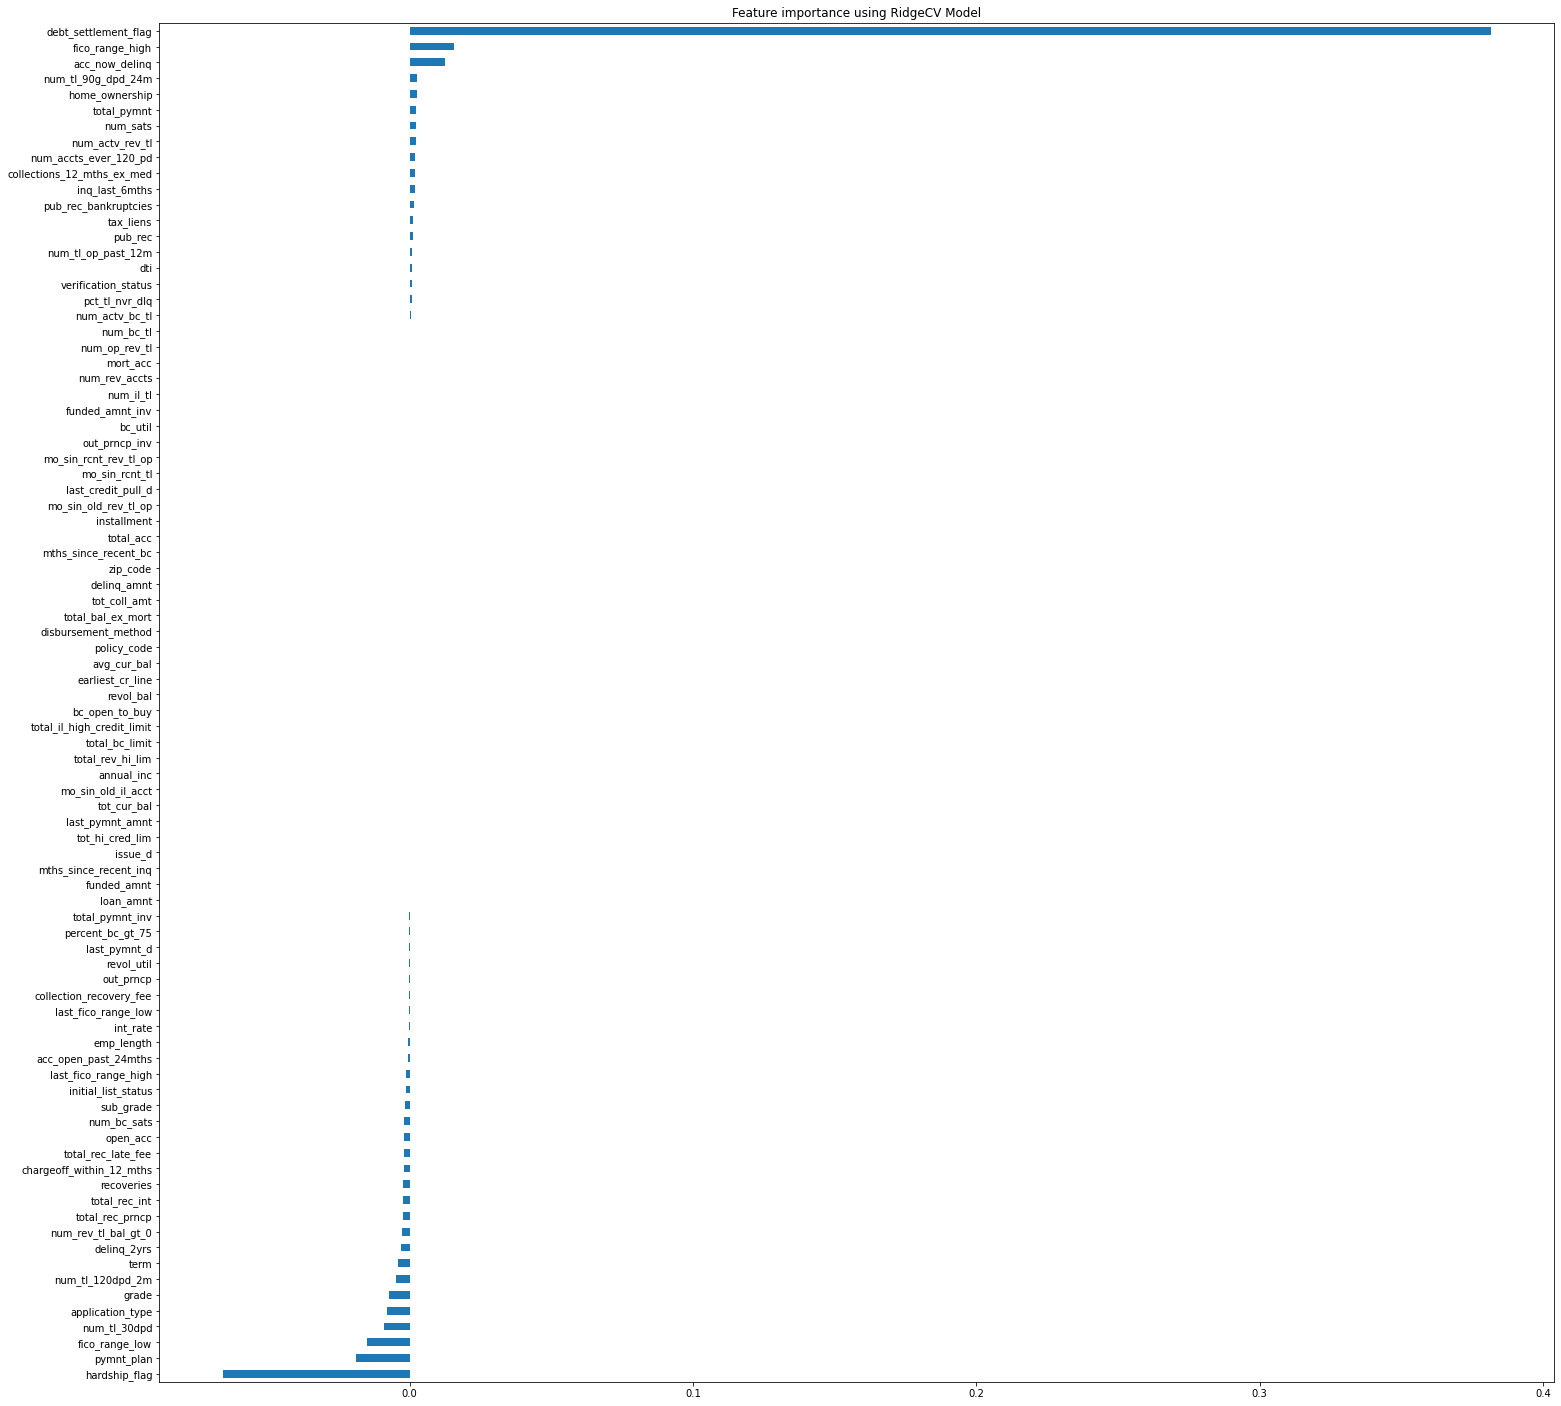

In [12]:
# keep as the main copy to work from, work with ds_

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
X, y = ds_.loc[:, ds_.columns != 'loan_status'], ds_['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)



# get feature importance before applying models
from sklearn.linear_model import RidgeCV
reg = RidgeCV()
reg.fit(X, y)


plt.figure(figsize = (25, 25))
imp_coef = pd.Series(reg.coef_, index = X.columns).sort_values()
imp_coef.plot(kind = "barh")
plt.title("Feature importance using RidgeCV Model")

ds_feature_impo = pd.DataFrame(list(zip(X.columns, reg.coef_)), columns = ['Column', 'Importance'])
ds_feature_impo

to avoid over fitting, we will only apply certain columns:

In [13]:
ds_feature_impo['Importance'] = ds_feature_impo['Importance'].abs()
ds_feature_impo.sort_values(by = ['Importance'])
most_impo = list(ds_feature_impo['Column'][-10:])
print(most_impo)
#now that we have our most important columns, we can break down to dummies our numerically relabeled categorcial feature variables 
ds = pd.get_dummies(ds, columns = cols_tobreak)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
X, y = ds.loc[:, ds.columns != 'loan_status'], ds['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


['percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [34]:
import time
from sklearn.metrics import accuracy_score

X, y = ds[most_impo], ds['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#define models:
models, times, accs, feature_count = [], [], [], []

count = 10
while count < len(ds_feature_impo):
    most_impo = list(ds_feature_impo['Column'][-count:])
    X, y = ds[most_impo], ds['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    model = LogisticRegression()
    start = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    end = time.time()
    score = accuracy_score(y_test, predictions)
    print(score * 100)
    models.append('Logistics Regression')
    times.append(round((end - start), 2))
    accs.append(score)
    feature_count.append(count)

    model = DecisionTreeClassifier()
    start = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    end = time.time()
    score = accuracy_score(y_test, predictions)
    print(score * 100)
    models.append('Decision Tree')
    times.append(round((end - start), 2))
    accs.append(score)

    model = GaussianNB()
    start = time.time()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    end = time.time()
    score = accuracy_score(y_test, predictions)
    print(score * 100)
    models.append('Bayes')
    times.append(round((end - start), 2))
    accs.append(score)
    print(count)
    count += 1



# model = RandomForestClassifier()
# start = time.time()
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# end = time.time()
# score = accuracy_score(y_test, predictions)
# print(score * 100)
# models.append('Random Forest')
# times.append(round((end - start), 2))
# accs.append(score)

# model = KNeighborsClassifier()
# start = time.time()
# model.fit(X_train, y_train)
# predictions = model.predict(X_test)
# end = time.time()
# score = accuracy_score(y_test, predictions)
# print(score * 100)
# models.append('KNN')
# times.append(round((end - start), 2))
# accs.append(score)



82.44500000000001
74.52499999999999
82.465
10
82.465
74.35000000000001
82.465
11
82.465
74.8275
82.465
12
82.465
75.03
82.465
13
82.465
74.855
82.465
14
82.465
74.86
82.465
15
82.465
74.6875
82.465
16
82.465
74.7425
82.4625
17
82.465
74.4575
82.4425
18
82.465
74.5825
82.4175
19
82.465
74.6025
82.39750000000001
20
82.465
74.5925
82.39
21
82.465
74.5
82.39
22
82.465
74.665
82.34
23
82.455
74.53999999999999
82.3275
24
82.465
74.6525
82.3275
25
82.465
74.35000000000001
82.31
26
82.4625
74.3825
82.215
27
82.4625
74.405
82.205
28
82.4625
74.4975
82.06
29
82.45
74.3075
81.61
30


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.4625
74.625
81.555
31


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.465
74.7125
81.4225
32


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.46
74.7625
81.745
33


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.465
74.49
81.74249999999999
34


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.46
74.5675
81.515
35


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.455
74.815
78.80749999999999
36


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.465
74.80499999999999
72.8275
37


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.4625
74.80250000000001
73.625
38


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.455
75.2025
67.6325
39


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.44500000000001
75.005
62.955000000000005
40


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.44749999999999
74.9825
59.185
41


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.45
74.9325
59.185
42


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.435
75.005
59.185
43


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.4175
75.065
59.185
44


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


82.4425
75.1925
59.18750000000001
45


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


83.565


KeyboardInterrupt: 

In [ ]:
deetlist = [models, times, accs]

models_ = pd.DataFrame(deetlist)
models_ = models_.T
models_.columns = ['model', 'time', 'accuracy']
models_

THe best three models were lostic regression (best), RandomForestClassifier, and decision tree classifier.
Let's use the three of them to build a stacking model.
We will additionally attempt to detect any potential anoamlies to verify out claims that our acuracy score of predictions is truly valid at 99.7325%

But we see that random forest is taking a concerning amount of time in comparison to the other models. So let's try to only stack two models

In [26]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('tree', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier())
]

model = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(), cv = 5)
start = time.time()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
end = time.time()
score = accuracy_score(y_test, predictions)
print(score * 100)
models.append('Stacking (DecisionTree -> LogisticRegression)')
times.append(round((end - start), 2))
accs.append(score)
deetlist = [models, times, accs]

models_ = pd.DataFrame(deetlist)
models_ = models_.T
models_.columns = ['model', 'time', 'accuracy']
models_

99.6575


,model,time,accuracy
0,Logistics Regression,9.66,0.997325
1,Decision Tree,11.62,0.9918
2,Random Forest,69.82,0.995425
3,KNN,42.83,0.90595
4,Bayes,2.51,0.850325
5,Stacking (DecisionTree -> LogisticRegression),382.03,0.996575
